데이터 준비 및 FFT 전처리

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드
abnormal = np.load("resampled_abnormal.npy")
normal = np.load("resampled_normal.npy")

# FFT 함수
def apply_fft(data, n_fft=None):
    if n_fft is None:
        n_fft = data.shape[1]
    fft_data = np.abs(np.fft.fft(data, n=n_fft))
    return fft_data[:, :n_fft // 2]

# FFT 적용
fft_abnormal = apply_fft(abnormal)
fft_normal = apply_fft(normal)

# 결합 및 라벨
X = np.concatenate((fft_normal, fft_abnormal), axis=0)
y = np.array([0] * len(fft_normal) + [1] * len(fft_abnormal))


# 정규화 및 reshape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled[..., np.newaxis]

# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


1D CNN 모델 학습

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

# 모델 정의
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_scaled.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(128, 3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
81/85 [===========================>..] - ETA: 0s - loss: 0.2256 - accuracy: 0.9161WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000015B78328798> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

결과 분석 및 시각화

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
43/43 [==============================] - 0s 2ms/step


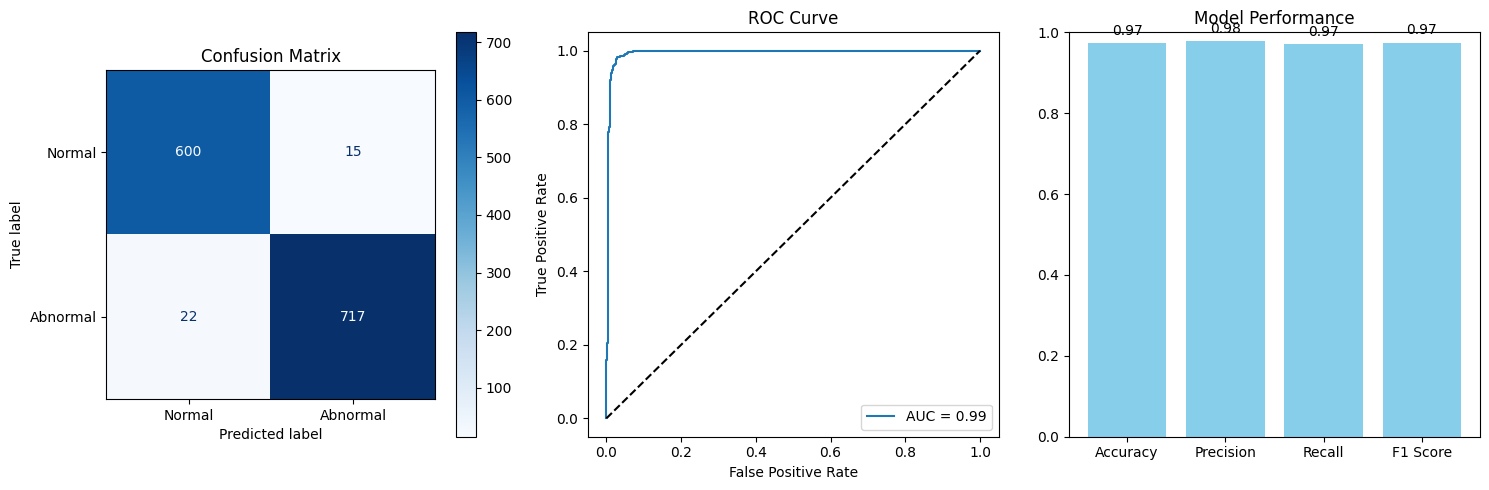

In [3]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt

# 예측
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# 지표 계산
acc = model.evaluate(X_test, y_test, verbose=0)[1]
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 시각화
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(ax=plt.gca(), cmap='Blues')
plt.title("Confusion Matrix")

# ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# 성능 지표 막대그래프
plt.subplot(1, 3, 3)
metrics = [acc, precision, recall, f1]
names = ["Accuracy", "Precision", "Recall", "F1 Score"]
plt.bar(names, metrics, color='skyblue')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.title("Model Performance")

plt.tight_layout()
plt.show()


결과가 심한데...

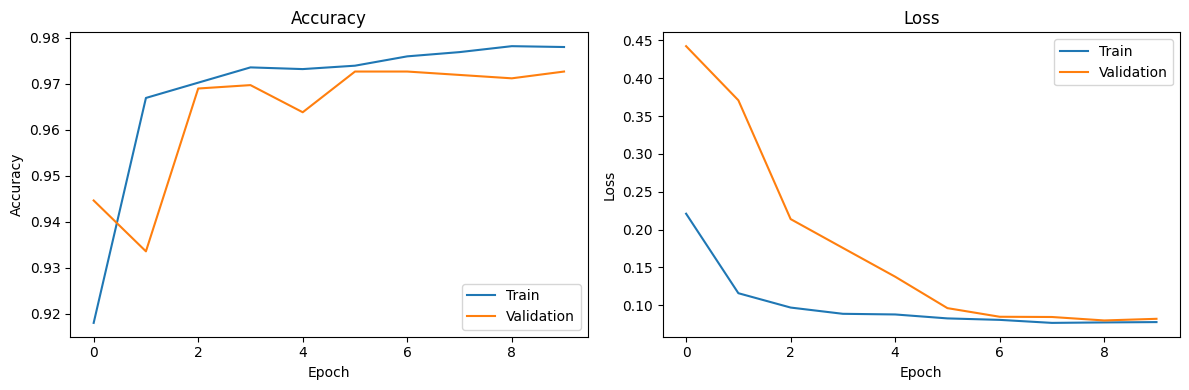

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


오버피팅은 아닌거 같기도하고 데이터가 골고루 안섞긴건가..?

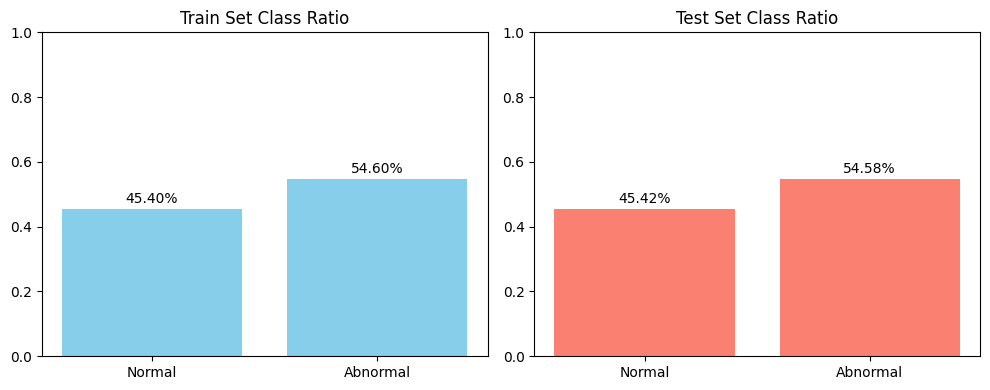

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 데이터 로드
abnormal = np.load("resampled_abnormal.npy")
normal = np.load("resampled_normal.npy")

# 결합 및 라벨 생성
X = np.concatenate((normal, abnormal), axis=0)
y = np.array([0] * len(normal) + [1] * len(abnormal))

# 셔플
X, y = shuffle(X, y, random_state=42)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 클래스 분포 계산
train_normal = np.sum(y_train == 0)
train_abnormal = np.sum(y_train == 1)
test_normal = np.sum(y_test == 0)
test_abnormal = np.sum(y_test == 1)

# 비율 계산
train_total = train_normal + train_abnormal
test_total = test_normal + test_abnormal

train_ratios = [train_normal / train_total, train_abnormal / train_total]
test_ratios = [test_normal / test_total, test_abnormal / test_total]

# 시각화
labels = ['Normal', 'Abnormal']
x = np.arange(len(labels))

plt.figure(figsize=(10, 4))

# Train Set 비율
plt.subplot(1, 2, 1)
plt.bar(x, train_ratios, color='skyblue')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Train Set Class Ratio")
for i, v in enumerate(train_ratios):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

# Test Set 비율
plt.subplot(1, 2, 2)
plt.bar(x, test_ratios, color='salmon')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("Test Set Class Ratio")
for i, v in enumerate(test_ratios):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center')

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import precision_score


# 1. 데이터 불러오기
test_n = np.load('normal_test_data.npy')      # 정상 샘플
test_abn = np.load('abnormal_test_data.npy')  # 이상 샘플

# 2. X, y 구성
X_test = np.concatenate([test_n, test_abn], axis=0)
y_test = np.array([0]*len(test_n) + [1]*len(test_abn))  # 0: 정상, 1: 이상

# 3. 전처리: 정규화 및 reshape
scaler = MinMaxScaler()
X_test_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])
X_test_scaled = X_test_scaled.reshape(-1, 100, 1)  # (샘플 수, 길이, 채널)

# 4. 모델 예측
y_pred_prob = model.predict(X_test_scaled)

# 5. 이진화 (0.5 기준으로)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# 6. 평가 지표 계산
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


17/17 [==============================] - 0s 4ms/step
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\mis-pc\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


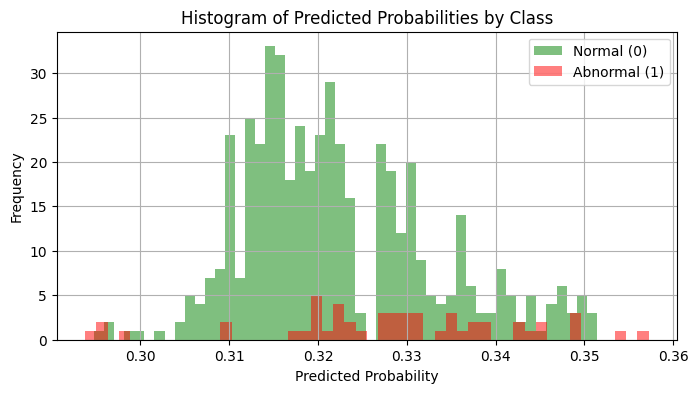

In [7]:
# 클래스별 확률 분포
plt.figure(figsize=(8, 4))

plt.hist(y_pred_prob[y_test == 0], bins=50, alpha=0.5, label='Normal (0)', color='green')
plt.hist(y_pred_prob[y_test == 1], bins=50, alpha=0.5, label='Abnormal (1)', color='red')

plt.title("Histogram of Predicted Probabilities by Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
